In [20]:
import string
import pandas as pd
import numpy as np
import nltk
import ssl

from bs4 import BeautifulSoup

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, auc, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn import ensemble
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from matplotlib import colors, pyplot as plt

import catboost as ctb
import lightgbm as lgb
import xgboost as xgb


try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gorinenko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/gorinenko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Постановка задачи

Задача состоит в автоматической генерации тегов на основе приведенного текста. Количество тегов может быть более одного. Данная проблема в ML называется "mulitlabel classification". Существует также схожая проблема "mulitclass classification", которая не относится к нашей задаче. Разница в том, что "mulitlabel classification" из множества классов предсказывает более одного класса, в тоже время "mulitclass classification" выбирает только один самый вероятный класс.

"Binary сlassification" - предсказание одного класса, при условии, что всего таках классов два.

Предсказывать теги нам потребуется на русском тексте, поэтому в качестве обучающего набора данных выбран русский раздел stackoverflow. Данный набор данных можно скачать по ссылке [Stack Exchange Data Dump](https://archive.org/details/stackexchange). Для преобразования xml документов в csv формат

# Предобработка текста

Загружаем корпус вопросов со stackoverflow на русском языке. Предобрабатываем колонку с тегами.

In [2]:
# file_path = 'data/stackoverflow_posts.csv'
file_path = 'data/stackexchange_posts.csv'

df = pd.read_csv(file_path)
df = df.iloc[:200, :]

In [3]:
df.fillna('', inplace=True)

In [4]:
def parse_tags(value):
    if isinstance(value, str):
        return ','.join(value.replace('<', '').split('>')).strip(',')
    
    return value
    
df["Tags"] = df["Tags"].apply(lambda x: parse_tags(x))

Предобрабатываем колонку "Body".

1. Приводим к нижнему регистру
2. Разбиваем на токены (слова)
3. Из списка токенов выкидываем стоп-слова и пунктуацию
4. Проводим леммитизацию и стемминг если надо

In [5]:
stop_words = set(stopwords.words('russian'))
punctuation = set(string.punctuation)


class TextPreProcessor:
  def __init__(self, tokenizer, stemmer=None, morph=None):
      self.tokenizer = tokenizer
      self.stemmer = stemmer
      self.morph = morph


  def tokenize(self, text: str):      
      text = text.lower()
      
      doc = BeautifulSoup(text, 'lxml')
      text = doc.text
      
      tokens = self.tokenizer.tokenize(text)
      
      words = [word for word in tokens if word not in stop_words and word not in punctuation]
      
      if self.morph:
          words = [self.morph.parse(word)[0].normal_form for word in words]

      if self.stemmer:
          words = [self.stemmer.stem(word) for word in words]

      return words
  
class NltkTokenizer:    
    def tokenize(self, text: str):      
        return list(word_tokenize(text))

In [6]:
def preprocessor(text):
    if not isinstance(text, str):
          return text
      
    tokenizer = TextPreProcessor(tokenizer=NltkTokenizer())    
    words = tokenizer.tokenize(text)
    return ' '.join(words)
    
df['Body_cleaned'] = df['Body'].apply(lambda x: preprocessor(x))

In [7]:
df.head(15)

,Id,Title,Body,Tags,Body_cleaned
0,1,"Genitive plural of ""башка""?",<p>What is the genitive plural and nominative ...,"грамматика,падежи,множественное-число,родитель...",what is the genitive plural and nominative plu...
1,1,"Genitive plural of ""башка""?",<p>What is the genitive plural and nominative ...,"грамматика,падежи,множественное-число,родитель...",what is the genitive plural and nominative plu...
2,2,When is it more appropriate to use здравствуйт...,"<p>As far as I understand, both of these mean ...","выбор-слова,formality,приветствия,этикет",as far as i understand both of these mean more...
3,2,When is it more appropriate to use здравствуйт...,"<p>As far as I understand, both of these mean ...","выбор-слова,formality,приветствия,этикет",as far as i understand both of these mean more...
4,3,,<p>Nominative plural is <em>башки</em>.</p>\n\...,,nominative plural is башки wiktionary says the...
5,3,,<p>Nominative plural is <em>башки</em>.</p>\n\...,,nominative plural is башки wiktionary says the...
6,4,,<p><strong>Здравствуйте</strong> is a more for...,,здравствуйте is a more formal version of приве...
7,4,,<p><strong>Здравствуйте</strong> is a more for...,,здравствуйте is a more formal version of приве...
8,5,How are short and long form adjectives used di...,<p>I'm confused by long form adjectives (which...,"грамматика,прилагательные",i 'm confused by long form adjectives which se...
9,5,How are short and long form adjectives used di...,<p>I'm confused by long form adjectives (which...,"грамматика,прилагательные",i 'm confused by long form adjectives which se...


Преобразуем колонку Tags в матрицу с закодированным представлением тегов

In [8]:
multi_label = MultiLabelBinarizer()
multi_label.fit(df["Tags"])
Y = multi_label.transform(df["Tags"])

# Feature Engineering

Получим векторное представление текстов колонки Body_cleaned с использованием TfidfVectorizer.

TfidfVectorizer формирует матрицу документы-слова, значения ячеек в которой является статистическая мера TF-IDF. 

TF-IDF (от англ. TF — term frequency, IDF — inverse document frequency) — статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален частоте употребления этого слова в документе и обратно пропорционален частоте употребления слова во всех документах коллекции.

Мера TF-IDF часто используется в задачах анализа текстов и информационного поиска, например, как один из критериев релевантности документа поисковому запросу, при расчёте меры близости документов при кластеризации. Также используется в задачах ранжирования и выделение ключевых слов.

Большой вес в TF-IDF получат слова с высокой частотой в пределах конкретного документа и с низкой частотой употреблений в других документах. Чем релевантнее слово к документу, тем больше значение TF-IDF. 

max_df - при построении словаря игнорируются слова, у которых частота появления в документах строго превышает заданный порог

max_features - максимальное количество наиболее часто встречающихся слов в словаре

In [9]:

tfidf= TfidfVectorizer(max_df=0.8, max_features=1000)

X_tf = tfidf.fit_transform(df["Body_cleaned"])


In [10]:
tfidf_df =  pd.DataFrame.sparse.from_spmatrix(X_tf, columns=tfidf.get_feature_names_out(), index=df["Body_cleaned"].index)
tfidf_df.head(10)

,10,20,3x,able,about,above,acquaintance,add,adjective,adjectives,...,юмор,юных,язык,языка,языке,مسجد,დიდი,იუ,კატა,ნაბახუსევი
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25383,0.278798,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25383,0.278798,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Обучение модели
Обучим различные классификаторы

In [15]:
random_state=42
device = 'cpu'
tree_method = 'auto' if device == 'cpu' else 'gpu_hist'
# 'eval_metric': 'TotalF1',
classifiers = (
    ('CatBoostClassifier', ctb.CatBoostClassifier, {'random_state': random_state, 'eval_metric': 'Accuracy', 'task_type': device.upper(), 'logging_level': 'Silent',  'loss_function': 'MultiCrossEntropy'} ),
    # ('LGBMClassifier', lgb.LGBMClassifier, {'objective': 'binary', 'metric': 'auc', 'device': device, 'random_state': random_state, 'verbosity': -1}),
    # ('XGBClassifier', xgb.XGBClassifier, {'eval_metric': 'auc', 'objective': 'binary:logistic', 'random_state': random_state, 'tree_method': tree_method, 'verbosity': 0}),
    # ('RandomForestClassifier', ensemble.RandomForestClassifier, {'random_state': random_state}),
    # ('AdaBoostClassifier', ensemble.AdaBoostClassifier, {'random_state': random_state}),
    # ('DecisionTreeClassifier', tree.DecisionTreeClassifier, {'random_state': random_state}),
    # ('LogisticRegression', LogisticRegression, {'random_state': random_state, 'solver': 'liblinear'}),
    # ('SVC', SVC, {'random_state': random_state, 'probability': True}),
    # ('GradientBoostingClassifier', ensemble.GradientBoostingClassifier, {'random_state': random_state}),
    # ('KNeighborsClassifier', KNeighborsClassifier, {}),
)

In [16]:
cv = KFold(n_splits=5, random_state=random_state, shuffle=True)


scores = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': []
}

model_ensemble = []

for name, classifier, train_params in classifiers:
    print(f'Start train {name} classifier.')   
      
    accuracy, precision, recall, f1, auc = [],[],[],[],[],
    
    for i, (train_index, test_index) in enumerate(cv.split(Y)):
        print(f'Start {i} fold for classifier {name}.')
            
        fold_X_train, fold_X_validate = X_tf[train_index], X_tf[test_index]
        fold_y_train, fold_y_validate = Y[train_index], Y[test_index]
                
        model = classifier(**train_params)
        model.fit(fold_X_train, fold_y_train)
        
        preds = model.predict(fold_X_validate)
        probs = model.predict_proba(fold_X_validate)
        
        accuracy.append(accuracy_score(fold_y_validate, preds))
        precision.append(precision_score(fold_y_validate, preds, zero_division=0))
        recall.append(recall_score(fold_y_validate, preds))
        f1.append(f1_score(fold_y_validate, preds))
        auc.append(roc_auc_score(fold_y_validate, probs[:,1]))
                
        model_ensemble.append(model)

    scores['accuracy'].append(round(np.mean(accuracy), 2) * 100)
    scores['precision'].append(round(np.mean(precision), 2) * 100)
    scores['recall'].append(round(np.mean(recall), 2) * 100)
    scores['f1'].append(round(np.mean(f1), 2) * 100)
    scores['auc'].append(round(np.mean(auc), 2) * 100)
    
    print('=====================\n')

Start train CatBoostClassifier classifier.
Start 0 fold for classifier CatBoostClassifier.


ValueError: Target is multilabel-indicator but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted', 'samples'].

In [17]:
test_error = pd.read_csv('catboost_info/learn_error.tsv', sep='\t')

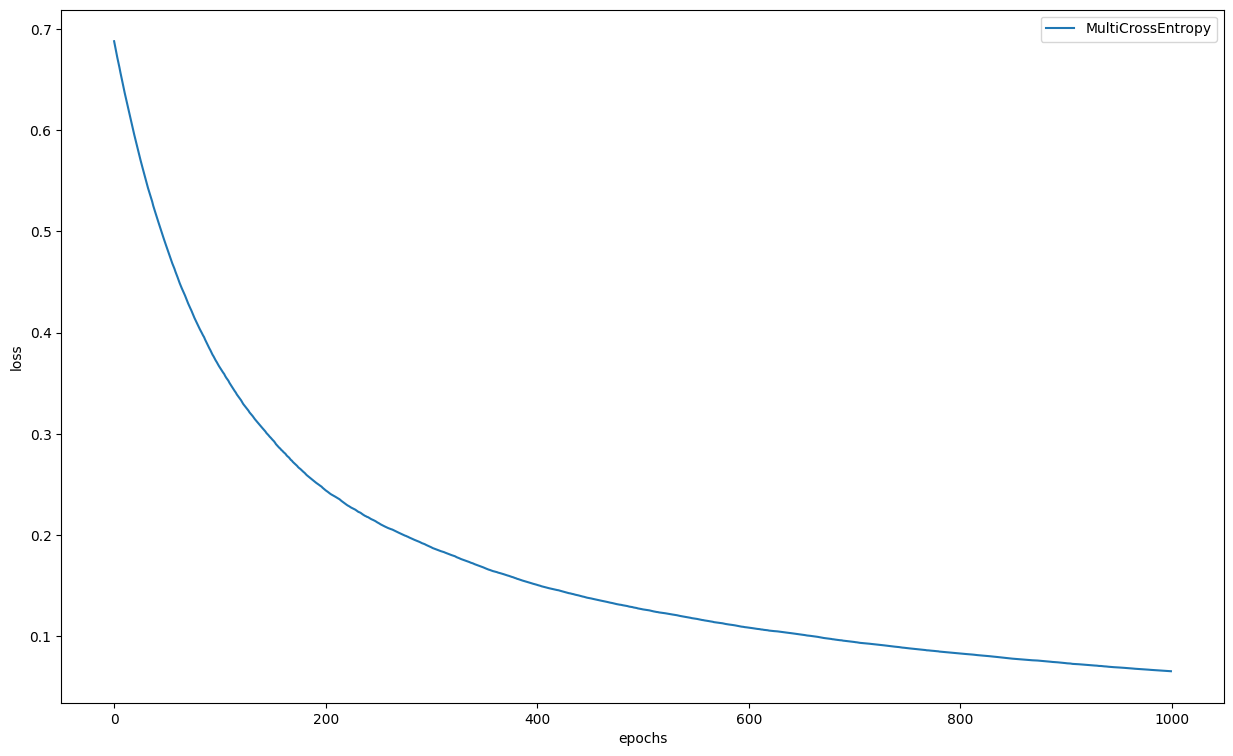

In [23]:
plt.figure(figsize=(15, 9))
plt.plot(test_error['MultiCrossEntropy'], label="MultiCrossEntropy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

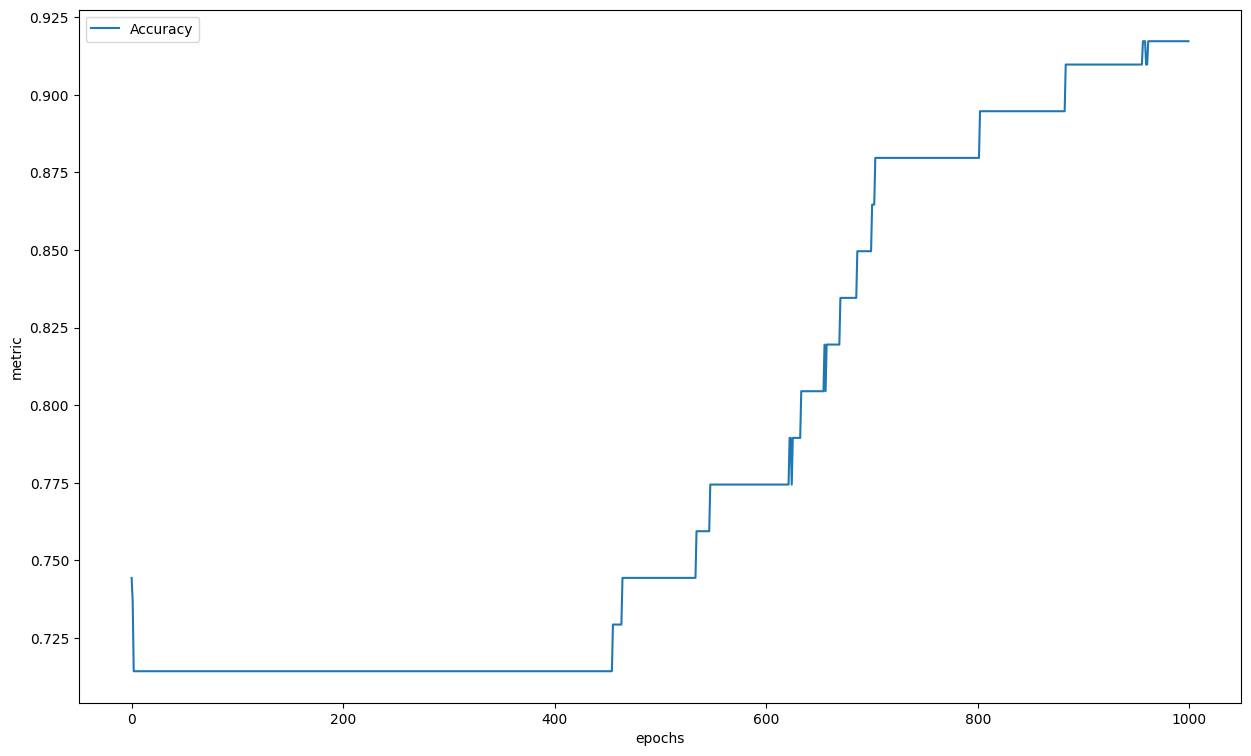

In [22]:
plt.figure(figsize=(15, 9))
plt.plot(test_error['Accuracy'], label="Accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("metric")
plt.show()

In [ ]:
# df.to_csv(f'data/stackoverflow_posts_cleaned.csv')
y



array([[0, 1, 0, 0, 0],
       [1, 1, 1, 0, 0],
       [0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 1, 1, 1, 0],
       [0, 0, 1, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0],
       [0, 1, 1, 1, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 0, 0],
       [1, 1, 0, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 1, 0, 0],
       [1, 1, 1, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 1, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 1, 1, 1, 1],
       [1, 1, 1, 0, 0],
       [0, 1, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 1, 0,